<h1><center>Computer Vision - Plant Seedlings Classification</center></h1>

## Background and Context

Can we differentiate a weed from a crop seedling? The ability to do so effectively can mean better crop yields and better stewardship of the environment. The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, hasrecently released a dataset containing images of unique plants belonging to 12 species at several growth stages

## Objective

The goal of the project is to create a classifier capable of determining a plant's species from a photo.

## Dataset

Dataset consist of two file
* images.npy - images data in numpy array format
* Label.csv - labels for each image in images.npy 

## Let's start coding!

### Installing  necessary library

In [1]:
!pip install opencv-python

### Loading necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns # for data visualization 
import tensorflow as tf
import tensorflow.keras as keras

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential #sequential api for sequential model 
from tensorflow.keras.layers import Dense, Dropout, Flatten #importing different layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical #to perform one-hot encoding 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam #optimiers for optimizing the model
from keras.callbacks import EarlyStopping  #regularization method to prevent the overfitting
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import losses, optimizers
from sklearn.metrics import accuracy_score, confusion_matrix

### Load the data for analysis

In [3]:
images = np.load('images.npy')
# Load the labels file of dataset
labels = pd.read_csv('Labels.csv')

### Shape of the data

In [4]:
seedling_category_count=labels.apply(pd.value_counts)

In [5]:
df_value_count = pd.DataFrame(seedling_category_count)
df_label_count = df_value_count.reset_index()
df_label_count.columns = ['Label', 'Count']

In [6]:
print("Images shape: "+ str(images.shape))
print("There are 4750 color images of size 128*128 of plant seedlings")
print("There are "+ str(labels.shape[0])+" images labels") 

Images shape: (4750, 128, 128, 3)
There are 4750 color images of size 128*128 of plant seedlings
There are 4750 images labels


## Exploratory Data Analysis on the images

### Images category count

In [7]:
labels['Label'].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
Name: Label, dtype: int64

### Dataset distribution for images

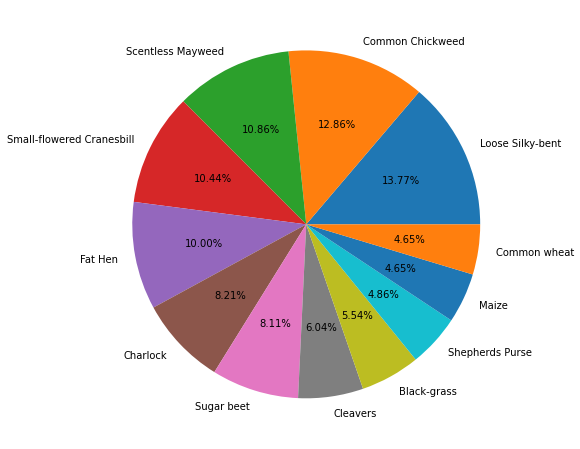

In [8]:
plt.figure(figsize=(8,8))
plt.pie(df_label_count['Count'],labels=df_label_count['Label'],autopct='%1.2f%%')
plt.show()

### Images from each class and their corresponding label

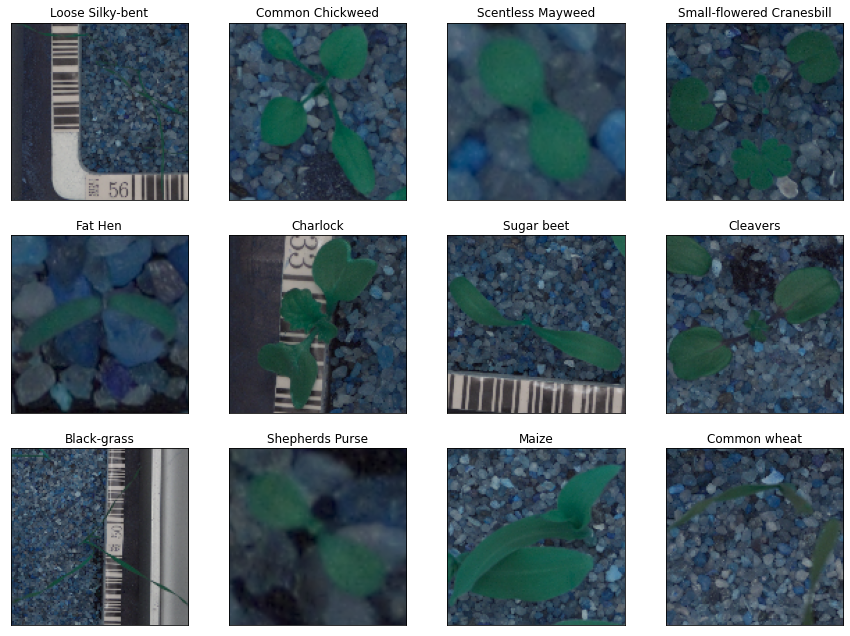

In [9]:
plt.figure(figsize=(15,15))
j=0
for label in df_label_count['Label']: 
    j=j+1
    plt.subplot(4,4,j)
    index = np.where(labels==label)[0][1]
    plt.imshow(images[index])
    plt.title(label)
    plt.xticks([]), plt.yticks([])

**Observation**
* There are 12 categories of plant seedlings
* Loose Silky-bent (654), Common Chickweed (611) and Scentless Mayweed (516) are the top three seedlings in the dataset with respect to their counts
* Shepherds Purse (231), Common wheat (221) and Maize (221) are the bottom three seedlings in the dataset with respect to their counts
* Images of the seedlings has background which might interfer with analysis becuase images of seedlings are small and a large portion of the images is of background
* Some of the images of the seedling are blur.

## Data Preprocessing

In [10]:
# Draw given before and after images side by side for comparision 
def drawBeforeAfterImages(categories,beforeImages, afterImages,subtitle):
    fig=plt.figure(figsize=(20,50))
    fig.suptitle(subtitle, fontsize=20)
    j=0
    for label in categories:
        j=j+1
        plt.subplot(12,4,j)
        index = np.where(labels==label)[0][1]
        plt.imshow(beforeImages[index])
        plt.title("Before: "+label)
        plt.xticks([]), plt.yticks([])

        j=j+1
        plt.subplot(12,4,j)
        index = np.where(labels==label)[0][1]
        plt.imshow(afterImages[index])
        plt.title("After: "+label)
        plt.xticks([]), plt.yticks([])
        
# Removes the background from image        
def removeBackgroundFromImgage(images):
    clean_image = []
    sets = [];
    for idx, image in enumerate(images):
        #Gaussian Blur
        blurr = cv2.GaussianBlur(image,(5,5),0)
        # BGR to HSV image
        hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
        #GREEN PARAMETERS
        lower = (25,40,50)
        upper = (75,255,255)
        mask = cv2.inRange(hsv,lower,upper)
        
        structure = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
        
        #Masking
        mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,structure)
        boolean = mask>0
        
        #Removal of background
        new = np.zeros_like(image,np.uint8)
        new[boolean] = image[boolean]
        clean_image.insert(idx,new)

    clean_image = np.asarray(clean_image)
    return clean_image

### Resizing of Images
As the images are already in 128*128 size, no resizing of images needed

### Cleaning of Images

### CNN Model 1

#### Gaussian Blur

Now we apply the gaussian blur to each 28x28 pixels array (image) to reduce the noise in the image

In [11]:
gaussian_blur_images = []
for idx, img in enumerate(images):
    gaussian_blur_images.insert(idx,cv2.GaussianBlur(img, (5, 5), 0))

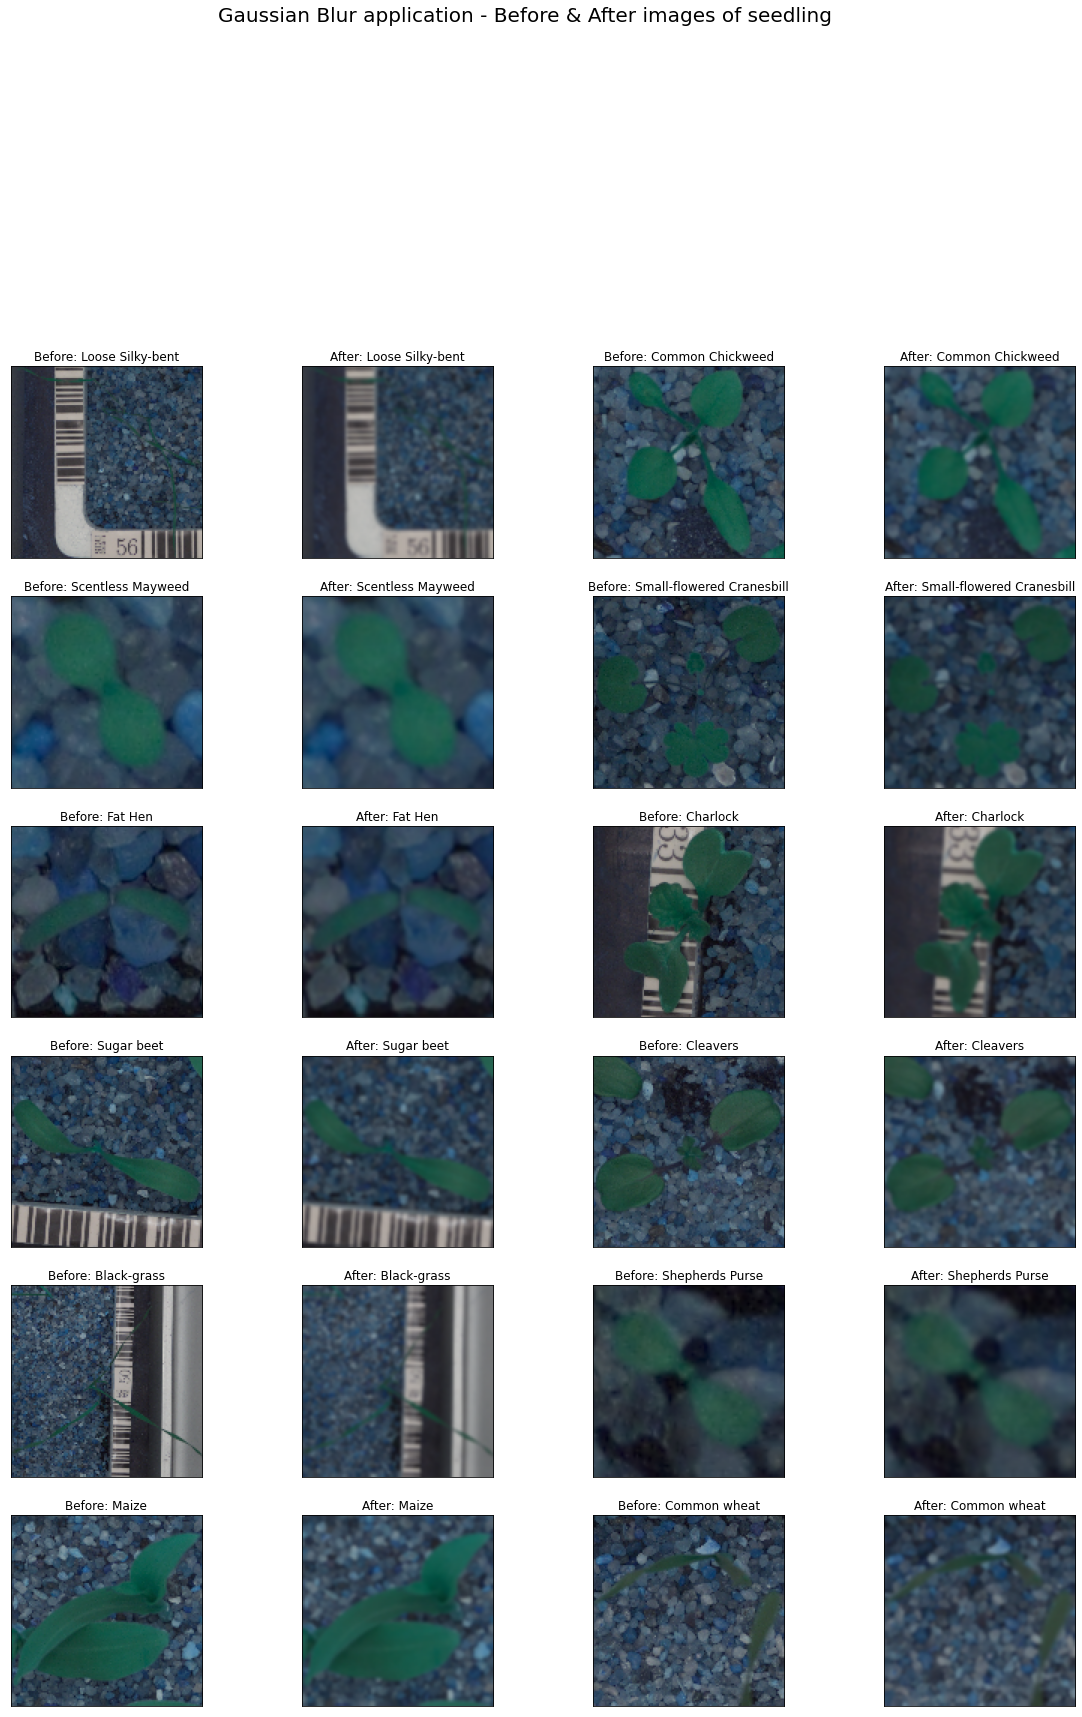

In [12]:
categories=df_label_count['Label']
drawBeforeAfterImages(categories,images,gaussian_blur_images,"Gaussian Blur application - Before & After images of seedling")

#### Normalization

Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network

In [13]:
IMG_SIZE=128
normalized_images = []
for idx, img in enumerate(gaussian_blur_images):
    normalized_img = img.reshape(-1,IMG_SIZE,IMG_SIZE)
    normalized_img = normalized_img/255.0 
    normalized_img = normalized_img.reshape(IMG_SIZE,IMG_SIZE,-1)
    normalized_images.insert(idx,normalized_img)

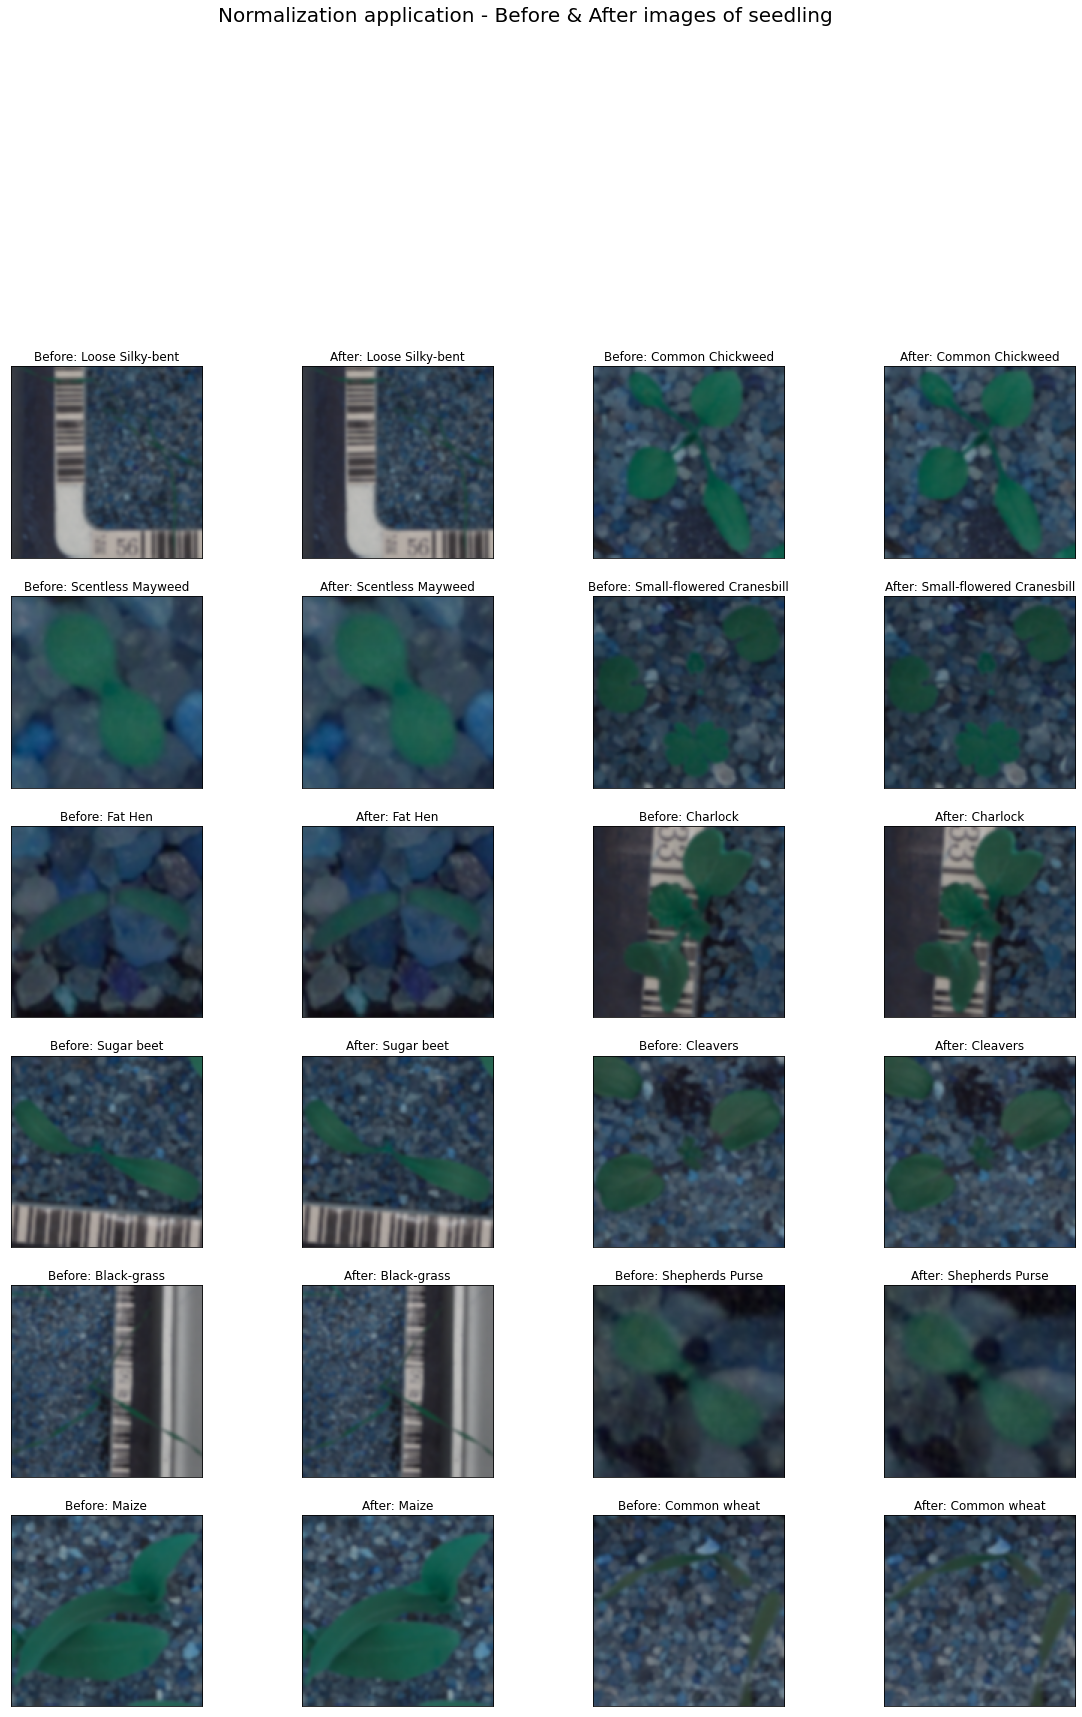

In [14]:
categories=df_label_count['Label']
drawBeforeAfterImages(categories,gaussian_blur_images,normalized_images,"Normalization application - Before & After images of seedling")

In [15]:
# Visulaising the sample result
training_images = np.asarray(normalized_images)

#### Shape of the images

In [16]:
img_shape=training_images.shape
print("There are "+ str(img_shape[0]) +" images of size "+str(img_shape[1])+"*"+str(img_shape[2])+" having "+str(img_shape[3])+" channel") 

There are 4750 images of size 128*128 having 3 channel


### CNN Model 2

#### Removal of background from seedling images

In [17]:
clean_image=removeBackgroundFromImgage(images)

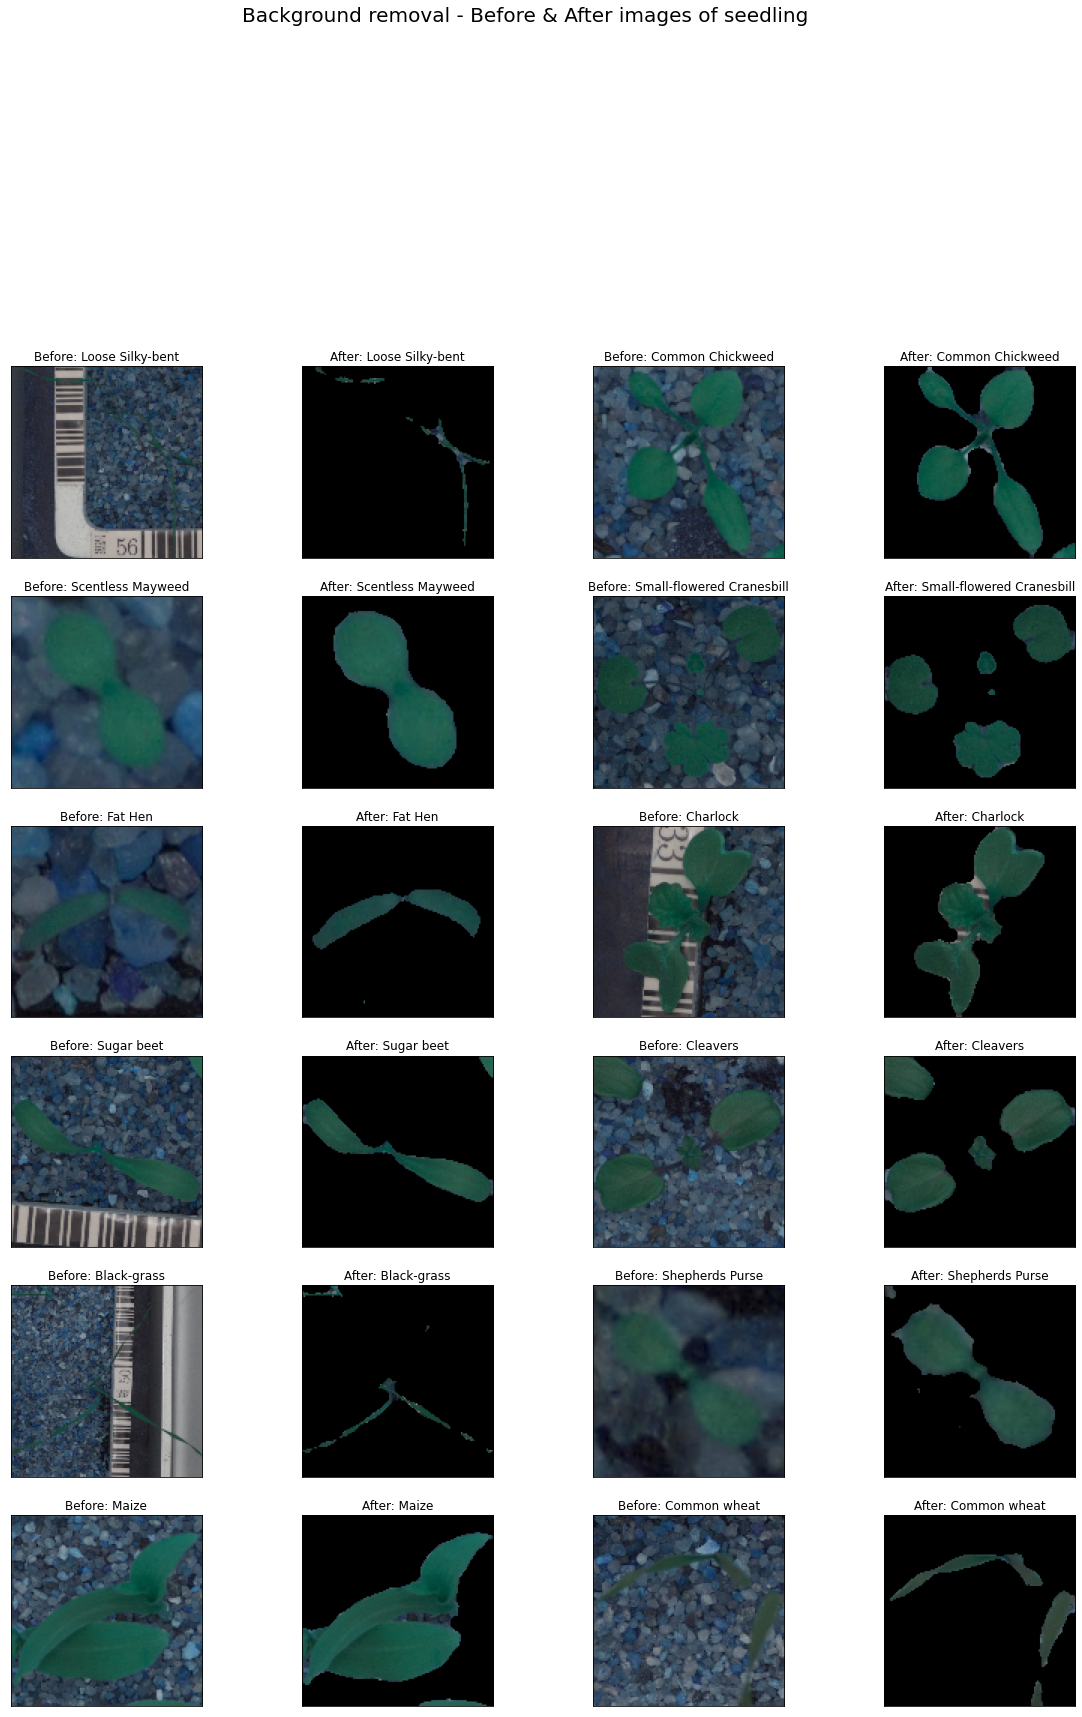

In [18]:
categories=df_label_count['Label']
drawBeforeAfterImages(categories,images,clean_image,"Background removal - Before & After images of seedling")

### Encoding y (Labels) variables 

In [19]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(labels)

##### Shape of data (y)

In [20]:
print("Shape of the data is "+ str(y.shape)) 

Shape of the data is (4750, 12)


## Model building

### Convolutional Neural Network (CNN)

#### CNN Model 1

#### Split the data into train and test

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(training_images,y , test_size=0.2, random_state=2,stratify=y)

In [22]:
generator = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1,width_shift_range = 0.1,height_shift_range = 0.1,horizontal_flip = True,vertical_flip = True)
generator.fit(X_train)

#### Model building

In [23]:
np.random.seed(2)
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(128, 128, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Flatten())

model.add(Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        3

#### Model Execution

In [24]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history=model.fit(X_train, 
          y_train,  #It expects integers because of the sparse_categorical_crossentropy loss function
          epochs=30, #number of iterations over the entire dataset to train on
          batch_size=64,validation_split=0.2,callbacks=[es, mc],use_multiprocessing=True)#number of samples per gradient update for training  


Epoch 1/30
48/48 [==============================] - 229s 5s/step - loss: 6.2240 - accuracy: 0.4724 - val_loss: 11.4358 - val_accuracy: 0.0921

Epoch 00001: val_accuracy improved from -inf to 0.09211, saving model to best_model.h5
Epoch 2/30
48/48 [==============================] - 210s 4s/step - loss: 3.1467 - accuracy: 0.7493 - val_loss: 26.5171 - val_accuracy: 0.1171

Epoch 00002: val_accuracy improved from 0.09211 to 0.11711, saving model to best_model.h5
Epoch 3/30
48/48 [==============================] - 210s 4s/step - loss: 1.6561 - accuracy: 0.8513 - val_loss: 52.7285 - val_accuracy: 0.1184

Epoch 00003: val_accuracy improved from 0.11711 to 0.11842, saving model to best_model.h5
Epoch 4/30
48/48 [==============================] - 216s 5s/step - loss: 0.8809 - accuracy: 0.9036 - val_loss: 65.2069 - val_accuracy: 0.1184

Epoch 00004: val_accuracy did not improve from 0.11842
Epoch 5/30
48/48 [==============================] - 228s 5s/step - loss: 0.6751 - accuracy: 0.9339 - val_l

**Observation**
* Validation accuracy of this model is very low. There is definitely scope of improvement. 
* Images are wrongly getting predicted - this could be due to background in the seedling images - which interferring with accuracy.
* Overall validation accuracy for Model 1 is 11.84%

### CNN Model 2

Lets try building another model with clean images ( removal of background from the seedling images)

#### Split the data into train and test

In [25]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(clean_image,y ,test_size=0.2, random_state=2,stratify=y)

#### Model Building

In [26]:
np.random.seed(2)
model1 = Sequential()
model1.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(128, 128, 3), activation='relu'))
model1.add(BatchNormalization())

model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.1))

model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.1))

model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.1))

model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model1.add(BatchNormalization())

model1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.1))
model1.add(Flatten())

model1.add(Dense(12, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 64)       

#### Model Execution

In [27]:
generator = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1,width_shift_range = 0.1,height_shift_range = 0.1,horizontal_flip = True,vertical_flip = True)
generator.fit(X_train1)

In [28]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history1=model1.fit(X_train1, 
          y_train1,  #It expects integers because of the sparse_categorical_crossentropy loss function
          epochs=30, #number of iterations over the entire dataset to train on
          batch_size=64,validation_split=0.2,callbacks=[es, mc],use_multiprocessing=True)#number of samples per gradient update for training  


Epoch 1/30
48/48 [==============================] - 180s 4s/step - loss: 1.6430 - accuracy: 0.4941 - val_loss: 7.7425 - val_accuracy: 0.2026

Epoch 00001: val_accuracy improved from -inf to 0.20263, saving model to best_model.h5
Epoch 2/30
48/48 [==============================] - 175s 4s/step - loss: 0.8848 - accuracy: 0.7063 - val_loss: 3.7156 - val_accuracy: 0.3382

Epoch 00002: val_accuracy improved from 0.20263 to 0.33816, saving model to best_model.h5
Epoch 3/30
48/48 [==============================] - 184s 4s/step - loss: 0.6113 - accuracy: 0.7961 - val_loss: 2.2085 - val_accuracy: 0.4697

Epoch 00003: val_accuracy improved from 0.33816 to 0.46974, saving model to best_model.h5
Epoch 4/30
48/48 [==============================] - 174s 4s/step - loss: 0.4538 - accuracy: 0.8451 - val_loss: 1.1748 - val_accuracy: 0.6553

Epoch 00004: val_accuracy improved from 0.46974 to 0.65526, saving model to best_model.h5
Epoch 5/30
48/48 [==============================] - 171s 4s/step - loss: 0.

**Observation**
* It is clear that model 2 is more generalized and accurate model
* Validation Accuracy of the model is 77.76%

### Plotting the Train & Test Accuracy

#### CNN Model 1

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


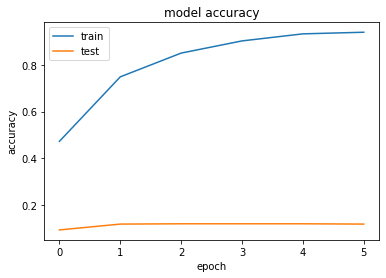

In [29]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### CNN Model 2

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


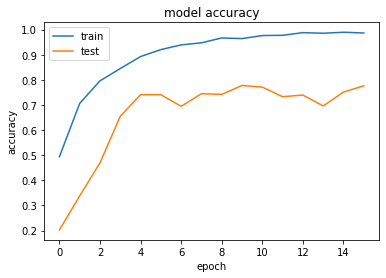

In [30]:
print(history1.history.keys())
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model Evaluation

#### CNN Model 1

In [31]:
model.evaluate(X_test,y_test)

30/30 [==============================] - 20s 670ms/step - loss: 104.3121 - accuracy: 0.1379


[104.31208801269531, 0.13789473474025726]

### CNN Model 2

In [32]:
model1.evaluate(X_test1,y_test1)

30/30 [==============================] - 15s 489ms/step - loss: 0.7204 - accuracy: 0.7937


[0.7203552722930908, 0.793684184551239]

**Observation**
* Model 2 accuracy is increased on test data. ie. it has 79.36% accuracy on test data as compared to 77.76% on validation data. 

### Plotting the confusion matrix for the two best models

#### CNN Model 1

In [33]:
# Test Prediction 
y_test_pred_ln1 = model.predict(X_test)
y_test_pred_classes_ln1 = np.argmax(y_test_pred_ln1, axis=1)
y_test_pred_prob_ln1 = np.max(y_test_pred_ln1, axis=1)

In [34]:
categories=df_label_count['Label']
y_pred = model.predict(X_test)
y_class = np.argmax(y_pred, axis = 1) 
y_check = np.argmax(y_test, axis = 1) 
cmatrix = confusion_matrix(y_check, y_class)

<AxesSubplot:>

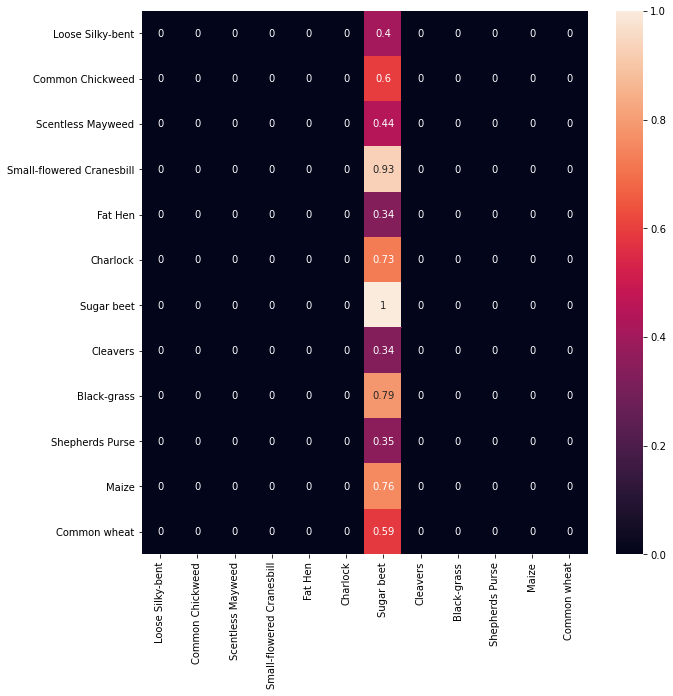

In [35]:
cmatrix = cmatrix/np.sum(cmatrix, axis=1)
plt.figure(figsize=(10,10))
sns.heatmap(cmatrix, xticklabels=categories, yticklabels=categories, annot=True)

<Figure size 1440x720 with 0 Axes>

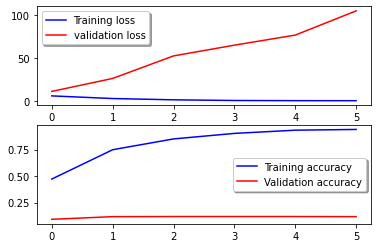

In [36]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### CNN Model 2

In [37]:
# Test Prediction 
y_test_pred_ln2 = model1.predict(X_test1)
y_test_pred_classes_ln2 = np.argmax(y_test_pred_ln2, axis=1)
y_test_pred_prob_ln2 = np.max(y_test_pred_ln2, axis=1)

In [38]:
categories=df_label_count['Label']
y_pred1 = model1.predict(X_test1)
y_class1 = np.argmax(y_pred1, axis = 1) 
y_check1 = np.argmax(y_test1, axis = 1) 
cmatrix1 = confusion_matrix(y_check1, y_class1)

<AxesSubplot:>

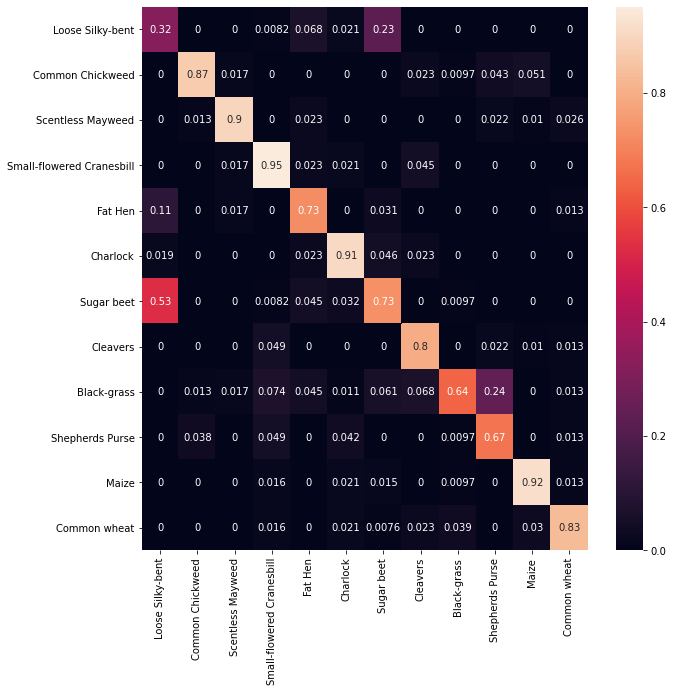

In [39]:
cmatrix1 = cmatrix1/np.sum(cmatrix1, axis=1)
plt.figure(figsize=(10,10))
sns.heatmap(cmatrix1, xticklabels=categories, yticklabels=categories, annot=True)

**Observation**
* As seen in the confusion matrix - Model 2 is able to predict most of the classes.
* Prediction percentage for Loose Silky-bent(26%)
* Loose Silky-bent is predicted as sugar beet by the model.

<Figure size 1440x720 with 0 Axes>

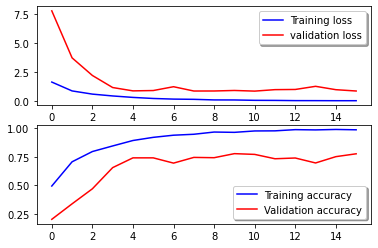

In [40]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(2,1)
ax[0].plot(history1.history['loss'], color='b', label="Training loss")
ax[0].plot(history1.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history1.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history1.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Conclusion & Insights

* There are 12 seedling images and some of the images is dominated by its background image
* Some of the images is blury in nature
* Best Model is CNN Model 2 with accuracy of (79.36%) on test data.  
* Accuracy of the model increased significantly when the images is cleaned by removing background
* Accuracy of the model can further be improved by introducing new hidden layers